In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

In [19]:
from topk_spade import *
from f2_spade import *

In [20]:
def imp(x):
    if(x == 1 or x == 0):
        return 0
    return -(x*np.log2(x))-((1-x)*np.log2(1-x))
    #return x*(1-x)

In [21]:
def check_subsequence(a,b):
    # This function check if b is a subsequence of a
    # a is the possible supersequence
    # b is the possible subsequence
    try:
        if len(b)<len(a):
            start=a.index(b[0])
            count=0
            for idx in range(len(a)-start):
                if count<len(b) and a[start+idx]==b[count]:
                    count+=1
            if count==len(b):
                return True
        return False
    except:
        return False

In [41]:
def k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc', printing=False):
    '''
    This function finds tok-k closed sequences with respect to a score defined by score_type ('wracc','abswracc','infogain')
    '''
    wracc_left=(P/total)*(N/total)
    Positive_seq_Discoverd=set(positive_seqs.keys())
    Negative_seq_Discoverd=set(negative_seqs.keys())
    To_discover=Positive_seq_Discoverd.union(Negative_seq_Discoverd)
    sequences={}
    
    for sequence in To_discover:
        p=positive_seqs.get(sequence,0)
        n=negative_seqs.get(sequence,0)
        if score_type=='wracc':
            score=wracc_left*((p/P)-(n/N))
        elif score_type=='abswracc':
            score=abs(wracc_left*((p/P)-(n/N)))
        elif score_type=='infogain':

            score=imp(P/total)-(((p+n)/(total))*imp(p/(p+n)))
            if (P != p or N!= n):
                #print((((P+N-p-n)/(total))*imp((P-p)/(P+N-p-n))))
                score-=(((P+N-p-n)/(total))*imp((P-p)/(P+N-p-n)))
        sequences[sequence]=[p,n,np.round(score,5),p+n]
    
    sorted_sequences=sorted(sequences.items(), key=lambda item: item[1][2],reverse=True)
    i=1
    j=0
    k_selected=[]
    prev=sorted_sequences[0][1][2]
    for sequence in sorted_sequences:
        if sequence[1][2]!=prev:
            i+=1
            prev=sequence[1][2]
        if i<=k:
            status=True
            possible_super=sequence[0]
            idx=0
            while idx<len(k_selected):
                possible_subsequence=k_selected[idx]
                if check_subsequence(possible_super,possible_subsequence):
                    if sequences[possible_super][3]==sequences[possible_subsequence][3]:

                        p=k_selected.pop(idx)
                        idx-=1
                
                if check_subsequence(possible_subsequence,possible_super):
                    if sequences[possible_super][3]==sequences[possible_subsequence][3]:
                        status=False
                idx+=1
            if status:
                k_selected.append(possible_super)
            j+=1
        else:
            break
    if printing==True:
        for sequence in k_selected:
            out='['+', '.join(list(sequence))+']'
            print(out,sequences[sequence][0],sequences[sequence][1],sequences[sequence][2])
            
    return set(k_selected)

In [42]:
def k_select(positive_seqs,negative_seqs,k,P,N,total):
    wracc_left=(P/total)*(N/total)
    Positive_seq_Discoverd=set(positive_seqs.keys())
    Negative_seq_Discoverd=set(negative_seqs.keys())
    To_discovere=Positive_seq_Discoverd.union(Negative_seq_Discoverd)
    sequences={}
    # the following wracc_x is added to compute weighted relative accuracy (Wracc)
    for sequence in To_discovere:
        wracc_x=wracc_left*((positive_seqs.get(sequence,0)/P)-(negative_seqs.get(sequence,0)/N))
        sequences[sequence]=[positive_seqs.get(sequence,0),negative_seqs.get(sequence,0),np.round(wracc_x,5)]

    sequences=sorted(sequences.items(), key=lambda item: item[1][2],reverse=True)
    i=1
    j=0
    prev=sequences[0][1][2]
    top_k_seq=[]
    for sequence in sequences:
        if sequence[1][2]!=prev:
            i+=1
            prev=sequence[1][2]
        if i<=k:
            top_k_seq.append(sequence[0])
            j+=1
        else:
            break
    return set(top_k_seq)

In [35]:
def get_sequence(selected):
    seqList=[]
    for i in selected:
        seqs=list(selected[i])
        for seq in seqs:
            seqList.append(seq)
    return set(seqList)

# Testing the algorithm 

In [71]:
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
selected=topk_spade(ds_positive, ds_negative,10,printing=False)
sequences=get_sequence(selected)

In [72]:
sequences

{('A',),
 ('E',),
 ('G',),
 ('L',),
 ('P',),
 ('R',),
 ('R', 'S'),
 ('S',),
 ('T',),
 ('V',),
 ('Y',)}

In [73]:
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)

In [74]:
top_k_seq_wracc=k_select(positive_seqs,negative_seqs,10,P,N,total)

In [75]:
top_k_seq_wracc

{('D', 'Y'),
 ('E', 'Y'),
 ('P', 'Y'),
 ('Y',),
 ('Y', 'A'),
 ('Y', 'D'),
 ('Y', 'G'),
 ('Y', 'P'),
 ('Y', 'V'),
 ('Y', 'Y')}

In [76]:
top_k_closed_warcc=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='wracc')


In [77]:
top_k_closed_warcc

{('D', 'Y'),
 ('E', 'Y'),
 ('P', 'Y'),
 ('Y',),
 ('Y', 'A'),
 ('Y', 'D'),
 ('Y', 'G'),
 ('Y', 'P'),
 ('Y', 'V'),
 ('Y', 'Y')}

# Finding common patterns

## Protein- shared patterns with top-k frequent miner

In [78]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
KS=[5,10,20,30,40,50,60,70,80,90,100]

common_wracc=[]
common_closed_wracc=[]
common_closed_abs=[]
common_closed_info=[]

for k in KS:
    selected=topk_spade(ds_positive, ds_negative,k,printing=False)
    baseline=get_sequence(selected)
    
    top_k_seq_wracc=k_select(positive_seqs,negative_seqs,k,P,N,total)
    common_wracc.append(len(baseline.intersection(top_k_seq_wracc))/len(baseline))
    
    top_k_closed_warcc=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc')
    common_closed_wracc.append(len(baseline.intersection(top_k_closed_warcc))/len(baseline))
    
    top_k_closed_abs=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='abswracc')
    common_closed_abs.append(len(baseline.intersection(top_k_closed_abs))/len(baseline))
    
    top_k_closed_info=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='infogain')
    common_closed_info.append(len(baseline.intersection(top_k_closed_info))/len(baseline))

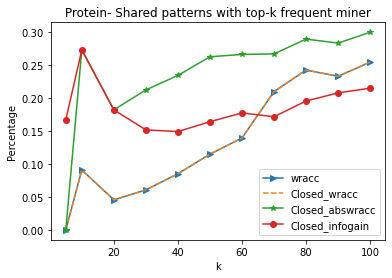

In [81]:
plt.figure(1)
plt.plot(KS,common_wracc,'->',label='wracc')
plt.plot(KS,common_closed_wracc,'--',label='Closed_wracc')
plt.plot(KS,common_closed_abs,'-*',label='Closed_abswracc')
plt.plot(KS,common_closed_info,'-o',label='Closed_infogain')
plt.title('Protein- Shared patterns with top-k frequent miner')
plt.xlabel('k')
plt.ylabel('Percentage')
plt.legend()

## Protein- shared patterns

In [95]:
def alg(alg_type):
    if alg_type=='top_k_frequent':
        selected=topk_spade(ds_positive, ds_negative,k,printing=False)
        res=get_sequence(selected)
    if alg_type=='top_k_wracc':
        res=k_select(positive_seqs,negative_seqs,k,P,N,total)
    if alg_type=='top_k_Closed_wracc':
        res=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc')
    if alg_type=='top_k_Closed_abswracc':
        res=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='abswracc')
    if alg_type=='top_k_Closed_infogain':
        res=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='infogain')
    return res

In [105]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
KS=[5,10,20,30,40,50,60,70,80,90,100]

common_wracc=[]
common_closed_wracc=[]
common_closed_abs=[]
common_closed_info=[]
share_score={}
algorithms=['top_k_frequent','top_k_wracc','top_k_Closed_wracc','top_k_Closed_abswracc','top_k_Closed_infogain']
for alg1 in algorithms:
    if alg1 not in share_score:
        share_score[alg1]={}
    for alg2 in algorithms:
        if alg1==alg2:
            share_score[alg1][alg2]=[1]*11
        else:
            share_score[alg1][alg2]=[]
        
for k in KS:
    selected=topk_spade(ds_positive, ds_negative,k,printing=False)
    baseline=get_sequence(selected)
    
    top_k_seq_wracc=k_select(positive_seqs,negative_seqs,k,P,N,total)
    common_wracc.append(len(baseline.intersection(top_k_seq_wracc))/len(baseline))
    
    top_k_closed_warcc=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc')
    common_closed_wracc.append(len(baseline.intersection(top_k_closed_warcc))/len(baseline))
    
    top_k_closed_abs=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='abswracc')
    common_closed_abs.append(len(baseline.intersection(top_k_closed_abs))/len(baseline))
    
    top_k_closed_info=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='infogain')
    common_closed_info.append(len(baseline.intersection(top_k_closed_info))/len(baseline))
    
    algorithms=['top_k_frequent','top_k_wracc','top_k_Closed_wracc','top_k_Closed_abswracc','top_k_Closed_infogain']

    # baseline
    share_score['top_k_frequent']['top_k_wracc'].append(len(baseline.intersection(top_k_seq_wracc))/len(baseline))
    share_score['top_k_wracc']['top_k_frequent'].append(len(baseline.intersection(top_k_seq_wracc))/len(baseline))
    
    share_score['top_k_frequent']['top_k_Closed_wracc'].append(len(baseline.intersection(top_k_closed_warcc))/len(baseline))
    share_score['top_k_Closed_wracc']['top_k_frequent'].append(len(baseline.intersection(top_k_closed_warcc))/len(baseline))
    
    share_score['top_k_frequent']['top_k_Closed_abswracc'].append(len(baseline.intersection(top_k_closed_abs))/len(baseline))
    share_score['top_k_Closed_abswracc']['top_k_frequent'].append(len(baseline.intersection(top_k_closed_abs))/len(baseline))

    share_score['top_k_frequent']['top_k_Closed_infogain'].append(len(baseline.intersection(top_k_closed_info))/len(baseline))
    share_score['top_k_Closed_infogain']['top_k_frequent'].append(len(baseline.intersection(top_k_closed_info))/len(baseline))
    
    #top_k_wracc
    share_score['top_k_wracc']['top_k_Closed_wracc'].append(len(top_k_seq_wracc.intersection(top_k_closed_warcc))/len(top_k_seq_wracc))
    share_score['top_k_Closed_wracc']['top_k_wracc'].append(len(top_k_seq_wracc.intersection(top_k_closed_warcc))/len(top_k_seq_wracc))

    share_score['top_k_wracc']['top_k_Closed_abswracc'].append(len(top_k_seq_wracc.intersection(top_k_closed_abs))/len(top_k_seq_wracc))
    share_score['top_k_Closed_abswracc']['top_k_wracc'].append(len(top_k_seq_wracc.intersection(top_k_closed_abs))/len(top_k_seq_wracc))

    share_score['top_k_wracc']['top_k_Closed_infogain'].append(len(top_k_seq_wracc.intersection(top_k_closed_info))/len(top_k_seq_wracc))
    share_score['top_k_Closed_infogain']['top_k_wracc'].append(len(top_k_seq_wracc.intersection(top_k_closed_info))/len(top_k_seq_wracc))

    #top_k_Closed_wracc
    share_score['top_k_Closed_wracc']['top_k_Closed_abswracc'].append(len(top_k_closed_warcc.intersection(top_k_closed_abs))/len(top_k_closed_warcc))
    share_score['top_k_Closed_abswracc']['top_k_Closed_wracc'].append(len(top_k_closed_warcc.intersection(top_k_closed_abs))/len(top_k_closed_warcc))

    share_score['top_k_Closed_wracc']['top_k_Closed_infogain'].append(len(top_k_closed_warcc.intersection(top_k_closed_info))/len(top_k_closed_warcc))
    share_score['top_k_Closed_infogain']['top_k_Closed_wracc'].append(len(top_k_closed_warcc.intersection(top_k_closed_info))/len(top_k_closed_warcc))
    
    #top_k_Closed_abswracc
    share_score['top_k_Closed_abswracc']['top_k_Closed_infogain'].append(len(top_k_closed_abs.intersection(top_k_closed_info))/len(top_k_closed_abs))
    share_score['top_k_Closed_infogain']['top_k_Closed_abswracc'].append(len(top_k_closed_abs.intersection(top_k_closed_info))/len(top_k_closed_abs))

In [106]:
share_score

{'top_k_frequent': {'top_k_frequent': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'top_k_wracc': [0.0,
   0.09090909090909091,
   0.045454545454545456,
   0.06060606060606061,
   0.0851063829787234,
   0.11475409836065574,
   0.13924050632911392,
   0.20952380952380953,
   0.2421875,
   0.23270440251572327,
   0.2542372881355932],
  'top_k_Closed_wracc': [0.0,
   0.09090909090909091,
   0.045454545454545456,
   0.06060606060606061,
   0.0851063829787234,
   0.11475409836065574,
   0.13924050632911392,
   0.20952380952380953,
   0.2421875,
   0.23270440251572327,
   0.2542372881355932],
  'top_k_Closed_abswracc': [0.0,
   0.2727272727272727,
   0.18181818181818182,
   0.21212121212121213,
   0.23404255319148937,
   0.26229508196721313,
   0.26582278481012656,
   0.26666666666666666,
   0.2890625,
   0.2830188679245283,
   0.2994350282485876],
  'top_k_Closed_infogain': [0.16666666666666666,
   0.2727272727272727,
   0.18181818181818182,
   0.15151515151515152,
   0.14893617021276595,
   0.1639

In [120]:
frame = pd.DataFrame(columns = ['Baseline']+algorithms)
counter=0
for alg1 in share_score:
    line=[alg1]
    for alg2 in share_score[alg1]:
        line.append(str(np.round(np.mean(share_score[alg1][alg2]),3))+' +/- '+ str(np.round(np.std(share_score[alg1][alg2]),3)))
    frame.loc[counter]=line
    counter+=1

In [122]:
frame.set_index('Baseline')

,top_k_frequent,top_k_wracc,top_k_Closed_wracc,top_k_Closed_abswracc,top_k_Closed_infogain
Baseline,,,,,
top_k_frequent,1.0 +/- 0.0,0.134 +/- 0.084,0.134 +/- 0.084,0.233 +/- 0.081,0.187 +/- 0.034
top_k_wracc,0.134 +/- 0.084,1.0 +/- 0.0,1.0 +/- 0.0,0.555 +/- 0.085,0.696 +/- 0.136
top_k_Closed_wracc,0.134 +/- 0.084,1.0 +/- 0.0,1.0 +/- 0.0,0.555 +/- 0.085,0.696 +/- 0.136
top_k_Closed_abswracc,0.233 +/- 0.081,0.555 +/- 0.085,0.555 +/- 0.085,1.0 +/- 0.0,0.739 +/- 0.097
top_k_Closed_infogain,0.187 +/- 0.034,0.696 +/- 0.136,0.696 +/- 0.136,0.739 +/- 0.097,1.0 +/- 0.0


## Reuters- shared patterns 

In [124]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('r-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('r-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.2,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
KS=[5,10,20,30,40,50,60,70,80,90,100]

share_score={}
algorithms=['top_k_frequent','top_k_wracc']
for alg1 in algorithms:
    if alg1 not in share_score:
        share_score[alg1]={}
    for alg2 in algorithms:
        if alg1==alg2:
            share_score[alg1][alg2]=[1]*11
        else:
            share_score[alg1][alg2]=[]
        
for k in KS:
    selected=topk_spade(ds_positive, ds_negative,k,printing=False)
    baseline=get_sequence(selected)
    
    top_k_seq_wracc=k_select(positive_seqs,negative_seqs,k,P,N,total)
    

    # baseline
    share_score['top_k_frequent']['top_k_wracc'].append(len(baseline.intersection(top_k_seq_wracc))/len(baseline))
    share_score['top_k_wracc']['top_k_frequent'].append(len(baseline.intersection(top_k_seq_wracc))/len(baseline))
    
 

In [125]:
frame = pd.DataFrame(columns = ['Baseline']+algorithms)
counter=0
for alg1 in share_score:
    line=[alg1]
    for alg2 in share_score[alg1]:
        line.append(str(np.round(np.mean(share_score[alg1][alg2]),3))+' +/- '+ str(np.round(np.std(share_score[alg1][alg2]),3)))
    frame.loc[counter]=line
    counter+=1

In [126]:
frame.set_index('Baseline')

,top_k_frequent,top_k_wracc
Baseline,,
top_k_frequent,1.0 +/- 0.0,0.342 +/- 0.166
top_k_wracc,0.342 +/- 0.166,1.0 +/- 0.0
